# Simple graph max cut example

In [89]:
from discopy.quantum.zx import *
from pyzx import draw

from sympy.abc import phi, beta

This notebook implements the simple graph from "Diagrammatic Analysis for Parameterized Quantum
Circuits" from chapter 4.3.

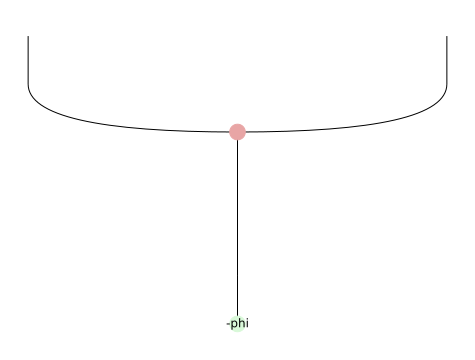

In [90]:
def get_phase_gadget(symbol):
    phase_gadget = X(2, 1) >> Z(1,0,symbol)
    return phase_gadget
phase_gadget = get_phase_gadget(-phi)
phase_gadget.draw()

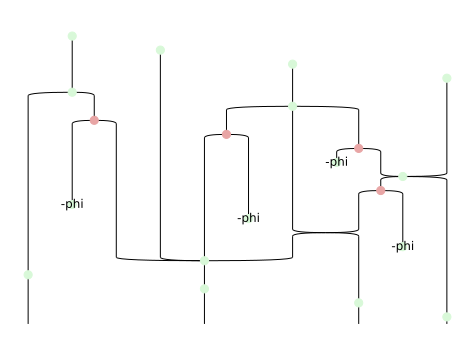

In [91]:
def get_beginning(symbol):
    diagram = Z(0, 1) @ Z(0, 1) @Z(0, 1) @Z(0, 1) 
    diagram = diagram >> Z(1, 2) @ Id(1) @ Z(1, 3) @ Id(1)
    diagram = diagram >> Id(1) @ X(1, 2) @ Id(1) @ X(1, 2) @Id(1) @ X(1, 2) @ Id(1)
    diagram = diagram >> Id(7) @ Z(1,0,symbol) @ Z(2, 2)
    diagram = diagram >> Id(7) @ X(1, 2) @ Id(1)
    diagram = diagram >> Id(1) @ Z(1,0,symbol) @ Id(3) @ Z(1,0,symbol) @ SWAP @ Z(1,0,symbol) @ Id(1)
    return diagram >> Id(1) @  Z(4, 1) @ Id(2) >> Z(1,1) @Z(1,1) @Z(1,1) @Z(1,1) 
stageone = get_beginning(-phi)
stageone.draw()
draw(stageone.to_pyzx())


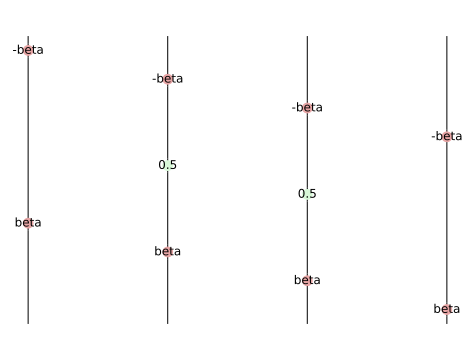

In [92]:
def get_middle(symbol):
    middle_part = X(1,1,-symbol) @ X(1,1,-symbol)@X(1,1,-symbol)@X(1,1,-symbol)
    middle_part = middle_part >> Id(1) @Z(1,1,phase=0.5) @ Z(1,1,phase=0.5) @ Id(1)
    middle_part = middle_part >> X(1,1,symbol) @ X(1,1,symbol)@X(1,1,symbol)@X(1,1,symbol)
    return middle_part
middle_part = get_middle(beta)
middle_part.draw()


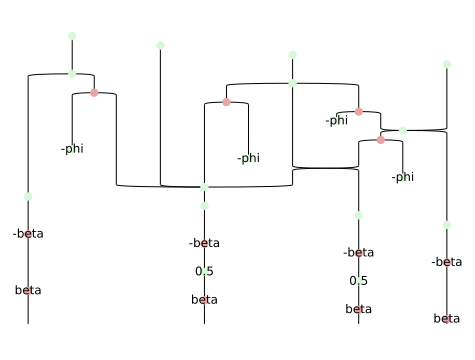

In [93]:
diagram = stageone >> middle_part

diagram.draw()

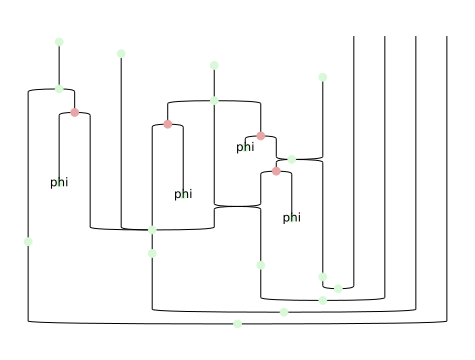

In [94]:
get_beginning(phi).transpose().draw()

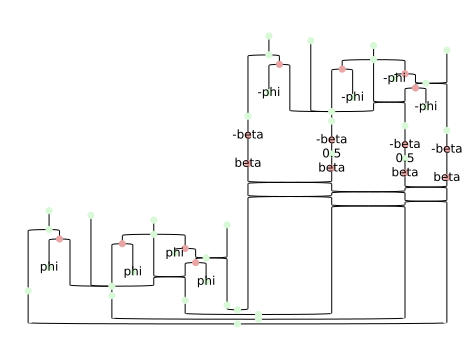

In [95]:
final_diag = diagram >> SWAP @ SWAP     >> Id(1) @ SWAP @ Id(1)         >> SWAP @ SWAP             >> Id(1) @ SWAP @ Id(1) >> get_beginning(phi).transpose()
final_diag.draw() 

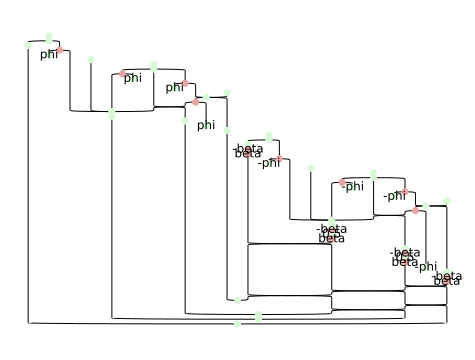

In [96]:
#final_diag.to_gif(*final_diag.normalize(), path="./large.gif")
final_diag.normal_form().draw()

In [97]:
from pyzx import draw as pyzxdraw
pyzx_final= final_diag.to_pyzx()
pyzx_final.normalize()
pyzxdraw(pyzx_final)

In [98]:
import pyzx as zx
#zx.simplify.spider_simp(pyzx_final)
pyzx_final.normalize()
zx.draw(pyzx_final)

In [99]:
from pyzx import VertexType
from fractions import Fraction
a = zx.rules.match_copy(pyzx_final)
phases = pyzx_final.phases()
types = pyzx_final.types()
c = []
for v in pyzx_final.vertices():
    #print("a", pyzx_final.phase(v), type(pyzx_final.phase(v)), isinstance(pyzx_final.phase(v), Fraction), pyzx_final.phase(v) == Fraction(1,1))
    if pyzx_final.phase(v) == Fraction(1,1):
        c.append(v)
print("candidates", c)
print("phases", [(x, phases[x]) for x in c])
edges = []
r_edges = []
for r in c:
    # prepre0 -> pre0 -> r -> pre1
    # prepre0 -> r -> pre0 -> pre1
    pre = list(pyzx_final.neighbors(r))
    pre_pre = list(pyzx_final.neighbors(pre[0]))
    pre_pre.remove(r)
    print("pre", pre)
    print("pre_pre", pre_pre)
    print(f"{pre_pre[0]} -> {pre[0]} -> {r} -> {pre[1]}")
    print(f"{pre_pre[0]} -> {r} -> {pre[0]} -> {pre[1]}")
    # pyzx_final.set_phase(pre[1], phases[pre[1]] * 2)
    r_edges.append((pre_pre[0], pre[0]))
    #r_edges.append((pre[0], r))
    r_edges.append((r, pre[1]))
    edges.append((pre_pre[0], r))
    edges.append((pre[0], pre[1]))
    #edges.append((r, pre[0]))
    pyzx_final.set_phase(pre[0], -1*phases[pre[0]])
print("edges", edges)
print("r_edges", r_edges)
for e in r_edges:
    pyzx_final.remove_edge(e)
for e in edges:
    pyzx_final.add_edge(e)

pyzx_final.normalize()
zx.draw(pyzx_final)


candidates [24, 25]
phases [(24, Fraction(1, 1)), (25, Fraction(1, 1))]
pre [21, 27]
pre_pre [17]
17 -> 21 -> 24 -> 27
17 -> 24 -> 21 -> 27
pre [22, 28]
pre_pre [18]
18 -> 22 -> 25 -> 28
18 -> 25 -> 22 -> 28
edges [(17, 24), (21, 27), (18, 25), (22, 28)]
r_edges [(17, 21), (24, 27), (18, 22), (25, 28)]


In [100]:
zx.simplify.spider_simp(pyzx_final)
pyzx_final.normalize()
zx.draw(pyzx_final)

spider_simp: 10. 9. 6. 1.  4 iterations


In [101]:
zx.simplify.id_simp(pyzx_final)
pyzx_final.normalize()
zx.draw(pyzx_final)

id_simp: 3. 1.  2 iterations


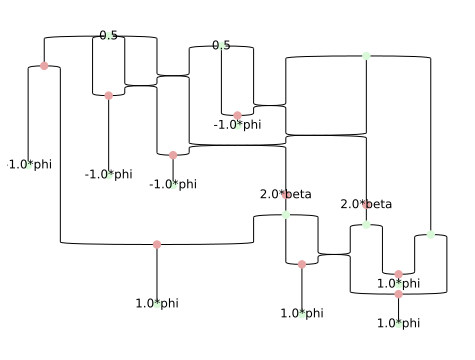

In [102]:
disco_diag = Diagram.from_pyzx(pyzx_final)
disco_diag.draw()

[16, 17]


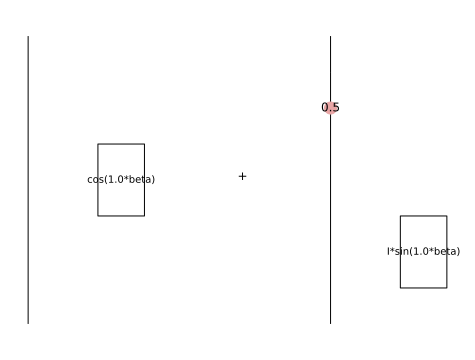

In [103]:
candidates = []
for i, box in enumerate(disco_diag.boxes):
    if isinstance(box, X) and box.phase == 2.0*beta:
        candidates.append(i)
print(candidates)

from discopy.monoidal import LocalSum
import sympy
def sum_from_Xspider(box):
    terms_left = Id(1) @ Scalar(sympy.cos(box.phase/2))
    terms_right = X(1, 1, 0.5) @ Scalar(sympy.I*sympy.sin(box.phase/2))
    return LocalSum([terms_left, terms_right]) 

sum = sum_from_Xspider(disco_diag.boxes[candidates[0]])
sum.draw()

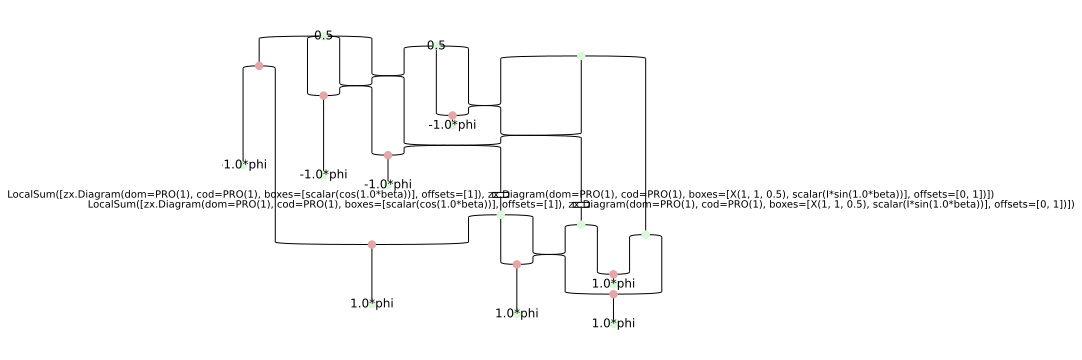

In [104]:
new_boxes = disco_diag.boxes

for candidate in candidates:
    new_boxes[candidate] = sum_from_Xspider(disco_diag.boxes[candidate])

from discopy.quantum.zx import Diagram as discoZxDiag
new_diag = discoZxDiag(disco_diag.dom, disco_diag.cod, new_boxes, disco_diag.offsets)
new_diag.draw()

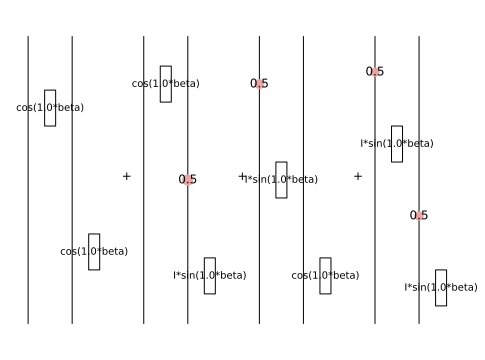

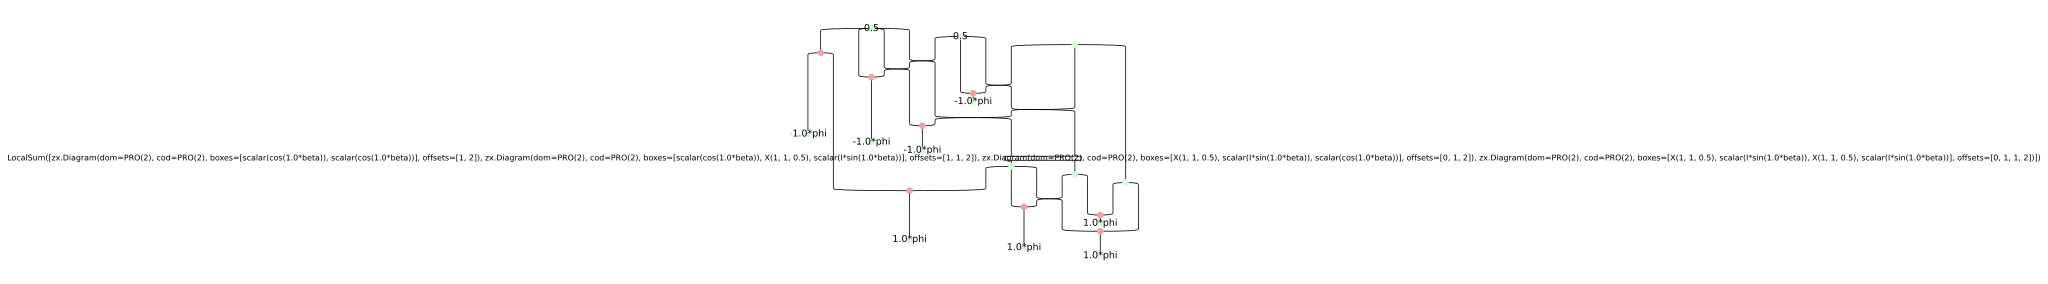

In [105]:
def combine_sums(diag, sum_index_first):
    """ This does not make even the most basic sanity checks!
        Parameters
        ----------
        diag: Diagram
        sum_index_first: int
            the index of the first sum, the second sum has to be directly behind
            the one behind is ASSUMED to be kroneker and not composed
    """
    assert(isinstance(diag.boxes[sum_index_first], LocalSum))
    assert(isinstance(diag.boxes[sum_index_first + 1], LocalSum))
    terms = []
    for term_left in diag.boxes[sum_index_first].terms:
        for term_right in diag.boxes[sum_index_first + 1].terms:
            terms += [term_left @ term_right]
    l = LocalSum(terms)
    l.draw()
    new_boxes =  diag.boxes[:sum_index_first] + [l] + diag.boxes[sum_index_first + 2:]
    return discoZxDiag(disco_diag.dom, disco_diag.cod, new_boxes, disco_diag.offsets[:sum_index_first + 1] + disco_diag.offsets[sum_index_first + 2:]) 
#print(new_diag.layers)
new_diag = combine_sums(new_diag, 16).draw()

Now for one of the subgraphs, in particular the I-X part:

2.0*beta


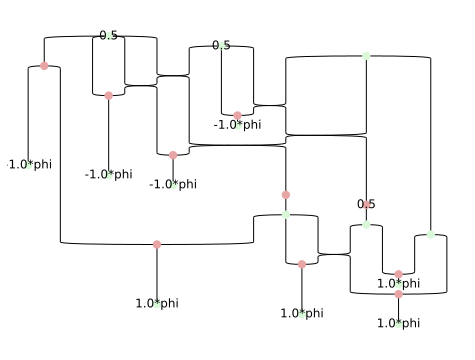

In [106]:
subgraph = disco_diag
def modify_for_example(diag):
    candidates = []
    for i, box in enumerate(disco_diag.boxes):
        if isinstance(box, X) and box.phase == 2.0*beta:
            candidates.append(i)
    print(diag.boxes[candidates[0]].phase )
    new_boxes = diag.boxes
    for i, v in [(0, 0), (1, 0.5)]:
        new_boxes[candidates[i]] = diag.boxes[candidates[i]].__class__(diag.boxes[candidates[i]].dom.l, diag.boxes[candidates[i]].cod.l, v)

    return discoZxDiag(diag.dom, diag.cod, new_boxes, disco_diag.offsets) 
subgraph = modify_for_example(subgraph)
subgraph.draw()

Now we simplify with pyzx:

In [107]:
final_example_zx = subgraph.to_pyzx()
draw(final_example_zx)
for i in range(3):
    print(i)
    zx.simplify.spider_simp(final_example_zx)
    zx.simplify.id_simp(final_example_zx)
final_example_zx.normalize()
zx.draw(final_example_zx)

0
spider_simp: 2.  1 iterations
id_simp: 1.  1 iterations
1
spider_simp: 1.  1 iterations
id_simp: 1.  1 iterations
2
spider_simp: 1.  1 iterations


In [108]:
x_pi_spiders = []
phases = final_example_zx.phases()
types = final_example_zx.types()
print(phases)
print(types)
for spider in final_example_zx.vertices():
    if phases[spider] == 1 and types[spider] == 2:
        x_pi_spiders.append(spider)

def commute_through_example(graph, spider, through):
    neighbours = graph.neighbors(spider)
    neighbours_through = graph.neighbors(through)
    assert(through in neighbours)
    assert all(types[x] == 2 for x in neighbours_through)
    for n in neighbours_through:
        if n == spider:
            graph.set_phase(n, phases[n] - 1)
        else:
            graph.set_phase(n, phases[n] + 1)
    return graph
        
for spi in x_pi_spiders:
    through = None
    for nei in final_example_zx.neighbors(spi):
        print("a", phases[nei], types[nei])
        if phases[nei] == 0 and types[nei] == 1:
            through = nei 
            break
    assert through is not None
    final_example_zx = commute_through_example(final_example_zx, spi, through) 

draw(final_example_zx)



{0: Fraction(1, 1), 1: Fraction(1, 1), 2: Fraction(0, 1), 4: 0, 5: 0, 6: -2.0*phi, 7: 0, 9: -2.0*phi, 10: -2.0*phi, 12: Fraction(1, 1), 14: 0, 17: 0, 18: 0, 19: 2.0*phi, 20: 0, 22: 2.0*phi, 23: 2.0*phi}
{0: 1, 1: 1, 2: 1, 4: 2, 5: 2, 6: 1, 7: 2, 9: 1, 10: 1, 12: 2, 14: 1, 17: 2, 18: 2, 19: 1, 20: 2, 22: 1, 23: 1}
a 1 1
a 0 1


In [109]:
for i in range(3):
    print(i)
    zx.simplify.spider_simp(final_example_zx)
    zx.simplify.id_simp(final_example_zx)
final_example_zx.normalize()
zx.draw(final_example_zx)

0
id_simp: 1.  1 iterations
1
spider_simp: 1.  1 iterations
2


we reintroduce an identity spider, so 

In [110]:
def find_example_spider(graph):
    types = graph.types()
    phases = graph.phases()
    for v in graph.vertices():
        if types[v] == 1 and phases[v] == 2.0*phi:
            nei = list(graph.neighbors(v))
            if len(nei) == 1 and phases[nei[0]] == 0:
                return nei[0]

types = final_example_zx.types()
phases = final_example_zx.phases()
find_example_spider(final_example_zx)
edges = []
re = []
for spi in final_example_zx.neighbors(find_example_spider(final_example_zx)):
    if types[spi] == 1 and phases[spi] == 1:
        new_v = final_example_zx.add_vertex(1, 0)
        edges.append((new_v, spi))
        for nei in final_example_zx.neighbors(spi):
            edges.append((new_v, nei))
            re.append((nei, spi))
print(edges)
print(re)
for e in re:
    final_example_zx.remove_edge(e)
for e in edges:
    final_example_zx.add_edge(e)

zx.draw(final_example_zx)


[(24, 0), (24, 4), (24, 7), (24, 17), (24, 20)]
[(4, 0), (7, 0), (17, 0), (20, 0)]


In [111]:
#print(i)
zx.simplify.spider_simp(final_example_zx)
#zx.simplify.id_simp(final_example_zx)
final_example_zx.normalize()
zx.draw(final_example_zx)

spider_simp: 1.  1 iterations
